In [1]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools

from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import tqdm
from tqdm.notebook import trange, tqdm
from torch.optim.lr_scheduler import MultiplicativeLR, LambdaLR

import matplotlib.pyplot as plt
from torchvision.utils import make_grid



In [2]:

def forward_diffusion_1d(x0, noise_strength_fn, t0, nsteps, dt):
    """
    
    :param x0:                init sample value  
    :param noise_strength_fn: function of time
    :param t0:                initial time
    :param nsteps:            number of diffusion steps
    :param dt:                time step size
    :return: 
    """
    x = np.zeros(nsteps + 1)
    x[0] = x0
    t = t0 + np.arange(nsteps + 1) * dt
    # Euler a time steps
    for i in range(nsteps):
        noise_strength = noise_strength_fn(t[i])
        random_normal = np.random.randn()
        x[i + 1] = x[i] + math.sqrt(dt) * noise_strength * random_normal
    return x, t

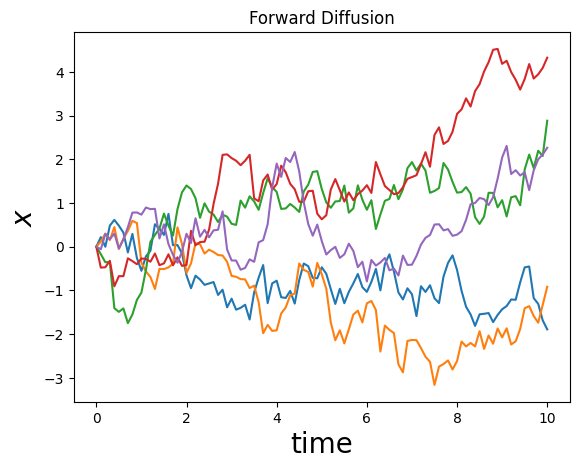

In [3]:
nsteps = 100
t0 = 0
dt = 0.1
noise_strength_fn = lambda t: 1
x0 = 0
num_tries = 5

for i in range(num_tries):
    x, t = forward_diffusion_1d(x0, noise_strength_fn, t0, nsteps, dt)
    plt.plot(t, x)
    plt.xlabel("time", fontsize=20)
    plt.ylabel("$x$", fontsize=20)
plt.title("Forward Diffusion",)
plt.show()

In [4]:
def reverse_diffusion_1d(x0, noise_strength_fn, score_fn, T, nsteps, dt):
    """
    
    :param x0:                  init sample value 
    :param noise_strength_fn:   function of time
    :param score_fn:            score function
    :param T:                   final time
    :param nsteps:              number of diffusion steps
    :param dt:                  time step size
    :return: 
    """
    x = np.zeros(nsteps + 1)
    x[0] = x0
    t = np.arange(nsteps + 1) * dt
    
    for i in range(nsteps):
        noise_strength = noise_strength_fn(T- t[i])
        score = score_fn(x[i], 0, noise_strength, T-t[i])
        random_normal = np.random.randn()
        x[i+1] = x[i] + noise_strength ** 2 * score *dt + noise_strength * math.sqrt(dt) * random_normal
    
    return x, t

In [5]:
def score_simple(x, x0, noise_strength, t):
    return -(x - x0) / ((noise_strength **2 ) * t)

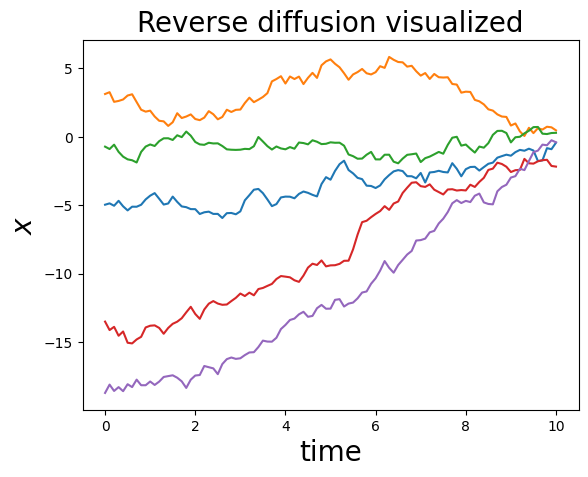

In [6]:
nsteps = 100
t0 = 0
dt = 0.1
noise_strength_fn = lambda t: 1
score_fn = score_simple
num_tries = 5
T = 11

for i in range(num_tries):
    x0 = np.random.normal(loc=0, scale=T)
    x, t = reverse_diffusion_1d(x0, noise_strength_fn, score_fn, T, nsteps, dt)
    plt.plot(t, x)
    plt.xlabel("time", fontsize=20)
    plt.ylabel("$x$", fontsize=20)
plt.title("Reverse diffusion visualized", fontsize=20)
plt.show()

In practice, we dont know the score function.
instead, we have to learn it.
One way to learn it is to train a neural network to 'denoise' sample via the denoising objective

*Unet*
which combnines a CNN-like structure with downscaling/upscaling operations that help the network pay attention to features of images at diffrent spatial scales.

Since the score function we're trying to learn is a function of time.
we also need to come up with a way to make sure our neural network properly response to change in time. we can use time embeddings.


In [22]:
# Helping our neural network work with time

class GaussianFourierProjection(nn.Module):
    def __init__(self, embed_dim, scale=30.):
        super(GaussianFourierProjection, self).__init__()
        # random sample weights during init
        # These weights are fixed during optimization and are not trainable. 
        # embed_dim 傅立叶变换中正弦和余弦总是成都出现
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
        
    
    def forward(self, x):
        # Cosine(2pi freq x), Sine(2pi freq x)
        x_proj = x[:, None] * self.W[None, :] * 2* np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)
    


In [23]:
class Dense(nn.Module):
    """
    fully connected layer that reshapes outputs to feature maps.
    allow time repr to input additively from the side of a convolutional layer.
    """
    def __init__(self, input_dim, output_dim):
        super(Dense, self).__init__()
        self.dense = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        return self.dense(x)[..., None, None]

In [34]:
# Define the U-Net architecture
class Unet(nn.Module):
    """
    A time-dependent score-based model built upon U-Net arch.
    """
    
    def __init__(self, marginal_prob_std, channels=(32, 64, 128, 256,), embed_dim=256):
        """
        Initialize a time-dependent score-based network.
        :param marginal_prob_std: 根据时间t扰动核的偏差
        :param channels:          the number of channels for feature maps of each resolution
        :param embed_dim:         the dimensionality of Gaussian random 
        """
        super(Unet, self).__init__()
        self.time_embed = nn.Sequential(
            GaussianFourierProjection(embed_dim),
            nn.Linear(embed_dim, embed_dim)
        )
        
        # Encoding layers where the resolution decreases
        self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
        
        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
        
        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
        
        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])
        
        # Decoding layers where the resolution increases
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
        
        self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1],3, stride=2, bias=False, output_padding=1)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
        
        self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1] , channels[0], 3, stride=2, bias=False, output_padding=1)
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
        self.tconv1 = nn.ConvTranspose2d(channels[0] +  channels[0], 1, 3, stride=1)
        
        self.act = lambda x: x * torch.sigmoid(x)
        self.marginal_prob_std = marginal_prob_std
        
    
    def forward(self, x, t, y=None):
        # Gaussian random feature embedding for t
        embed = self.act(self.time_embed(t))

        # Encoding
        h1 = self.conv1(x) + self.dense1(embed)
        h1 = self.act(self.gnorm1(h1))
        h2 = self.conv2(h1) + self.dense2(embed)
        h2 = self.act(self.gnorm2(h2))
        h3 = self.conv3(h2) + self.dense3(embed)
        h3 = self.act(self.gnorm3(h3))
        h4 = self.conv4(h3) + self.dense4(embed)
        h4 = self.act(self.gnorm4(h4))
        
        # Decoding path
        h = self.tconv4(h4)
        # Skip connection from encoding path
        h += self.dense5(embed)
        h = self.act(self.tgnorm4(h))
        
        h = self.tconv3(torch.cat([h, h3], dim=1))
        h += self.dense6(embed)
        h = self.act(self.tgnorm3(h))
        
        h = self.tconv2(torch.cat([h, h2], dim=1))
        h += self.dense7(embed)
        h = self.act(self.tgnorm2(h))
        
        h = self.tconv1(torch.cat([h, h1], dim=1))
        
        # Normalize output
        h = h / self.marginal_prob_std(t)[:, None, None, None]
        return h
        

In [50]:
device = "mps"

def marginal_prob_std(t, sigma):
    """
    Compute the mean and standard deviation 
    :param t: 
    :param sigma: 
    :return: 
    """

    t = t.clone().detach().requires_grad_(False)
    return torch.sqrt((sigma**(2*t) - 1.) /2./np.log(sigma))


def diffusion_coeff(t, sigma):
    """
    compute the diffusion coefficient of our SDE.
    :param t: 
    :param sigma: 
    :return: 
    
    """
    return torch.tensor(sigma**t, device=device)

sigma = 25.0
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [42]:
def loss_fn(model, x, marginal_prb_std_fn, eps=1e-5):
    """
    The loss function for training score-based generative models
    :param model: 
    :param x: 
    :param marginal_prb_std_fn: 
    :param eps: 
    :return: 
    """
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
    std = marginal_prb_std_fn(random_t)
    z = torch.randn_like(x)
    perturbed_x = x + std[:, None, None, None] * z
    score = model(perturbed_x, random_t)
    loss = torch.mean(torch.sum((score * std[:, None, None, None] + z) ** 2, dim=(1, 2, 3)))
    return loss

In [48]:
num_steps = 500

def Euler_Maruyama_sampler(
        score_model,
        marginal_prob_std,
        diffusion_coeff,
        batch_size=64,
        x_shape=(1, 28, 28),
        num_steps=num_steps,
        device=device,
        eps=1e-3,
        y=None
):
    """
    
    :param score_model: pytorch model represnets the time-dependent score-based model.
    :param marginal_prob_std:  function that gives the standard deviation of the perturbation kernel
    :param diffusion_coeff:    function that gives the diffusion coefficient of the SDE
    :param batch_size:        the number of samplers to generate by calling this function once
    :param x_shape:         
    :param num_steps: 
    :param device: 
    :param eps:              the samllest time step for numberical stability.
    :param y: 
    :return: 
    """
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, *x_shape, device=device) * marginal_prob_std(t)[:, None, None, None]
    
    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    with torch.no_grad():
        for time_step in tqdm(time_steps):
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            g = diffusion_coeff(batch_time_step)
            mean_x = x + (g ** 2)[:, None,None, None] * score_model(x, batch_time_step, y=y) * step_size
            x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)
    return mean_x
     

In [44]:
score_model = Unet(marginal_prob_std=marginal_prob_std_fn)
score_model = score_model.to(device)

n_epochs = 30
batch_size = 64
lr = 5e-4

dataset = MNIST(root='./data', transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True,  num_workers=4)

optimizer = Adam(score_model.parameters(), lr=lr)
tqdm_epoch = trange(n_epochs)

for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x, y in tqdm(data_loader):
        x = x.to(device)
        loss = loss_fn(score_model, x, marginal_prob_std_fn)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
        # print(f"Current :loss {loss:5f}")
    print('Average Loss: {:5f}'.format(avg_loss / num_items))
    torch.save(score_model.state_dict(), 'ckpt.pth')
    

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Average Loss: 206.070192


  0%|          | 0/938 [00:00<?, ?it/s]

Average Loss: 49.737577


  0%|          | 0/938 [00:00<?, ?it/s]

Average Loss: 38.348943


  0%|          | 0/938 [00:00<?, ?it/s]

Average Loss: 33.649244


  0%|          | 0/938 [00:00<?, ?it/s]

Average Loss: 28.699333


  0%|          | 0/938 [00:00<?, ?it/s]

Average Loss: 25.929000


  0%|          | 0/938 [00:00<?, ?it/s]

Average Loss: 24.234777


  0%|          | 0/938 [00:00<?, ?it/s]

Average Loss: 22.978267


  0%|          | 0/938 [00:00<?, ?it/s]

Average Loss: 21.621838


  0%|          | 0/938 [00:00<?, ?it/s]

Average Loss: 21.208257


  0%|          | 0/938 [00:00<?, ?it/s]

Average Loss: 20.848366


  0%|          | 0/938 [00:00<?, ?it/s]

Average Loss: 20.441563


  0%|          | 0/938 [00:00<?, ?it/s]

Average Loss: 20.036779


  0%|          | 0/938 [00:00<?, ?it/s]

Average Loss: 19.352461


  0%|          | 0/938 [00:00<?, ?it/s]

Average Loss: 19.217569


  0%|          | 0/938 [00:00<?, ?it/s]

Average Loss: 19.010994


  0%|          | 0/938 [00:00<?, ?it/s]

Average Loss: 18.843474


  0%|          | 0/938 [00:00<?, ?it/s]

Average Loss: 18.634717


  0%|          | 0/938 [00:00<?, ?it/s]

Average Loss: 18.644024


  0%|          | 0/938 [00:00<?, ?it/s]

Average Loss: 18.449552


  0%|          | 0/938 [00:00<?, ?it/s]

Average Loss: 18.272907


  0%|          | 0/938 [00:00<?, ?it/s]

Average Loss: 18.572885


  0%|          | 0/938 [00:00<?, ?it/s]

Average Loss: 18.062118


  0%|          | 0/938 [00:00<?, ?it/s]

Average Loss: 17.925507


  0%|          | 0/938 [00:00<?, ?it/s]

Average Loss: 17.799492


  0%|          | 0/938 [00:00<?, ?it/s]

Average Loss: 17.842889


  0%|          | 0/938 [00:00<?, ?it/s]

Average Loss: 17.745058


  0%|          | 0/938 [00:00<?, ?it/s]

Average Loss: 17.746388


  0%|          | 0/938 [00:00<?, ?it/s]

Average Loss: 17.746458


  0%|          | 0/938 [00:00<?, ?it/s]

Average Loss: 17.353300


In [51]:
sample_batch_size = 64
num_steps = 500
sampler = Euler_Maruyama_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn,
                                 sample_batch_size,num_steps=num_steps, device=device, y=None)
samples = sampler.clamp(0.0, 1.0)


  0%|          | 0/500 [00:00<?, ?it/s]

/var/folders/tm/xwv4p1wn0_sc501p0_zmpcwc0000gn/T/ipykernel_70793/345452296.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


In [53]:
%matplotlib inline
import matplotlib.pyplot as plt

simple_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

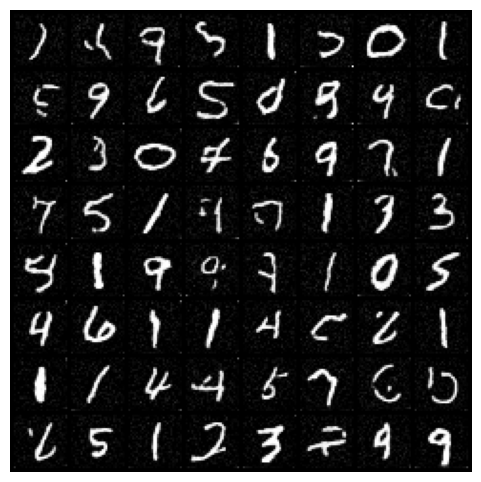

In [56]:
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(simple_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

### Using Attention to get conditional generation to work

In [57]:
from einops import rearrange
import math

In [58]:
class WordEmbed(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super().__init__()
        self.embed = nn.Embedding(vocab_size + 1, embed_dim)
        
    def forward(self, ids):
        return self.embed(ids)


we usually implement attention models using 3 parts:

- *CrossAttention* write a module to do self/cross attention for *sequences*
- *TransformerBlock* Combine self/cross-attention and a feed-forward neural network
- *SpatialTransformer* To use attention in a Unet, transform the spatial tensor to a sequential tensor and back


In [67]:
class CrossAttention(nn.Module):
    """
    just implemented  attention
    """

    def __init__(self, embed_dim, hidden_dim, context_dim=None, num_heads=3):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.context_dim = context_dim
        self.embed_dim = embed_dim
        self.query = nn.Linear(hidden_dim, embed_dim, bias=False)
        if context_dim is None:
            self.self_attn = True
            self.key = nn.Linear(hidden_dim, embed_dim, bias=False)
            self.value = nn.Linear(hidden_dim, hidden_dim, bias=False)
        else:
            self.self_attn = False
            self.key = nn.Linear(context_dim, embed_dim, bias=False)
            self.value = nn.Linear(context_dim, embed_dim, bias=False)
        
    def forward(self, tokens, context=None):
        """
        
        :param tokens: with shape [batch, seq_len, hidden_dim] 
        :param context:  shape [ batch, context_len, context_dim]
        :return: 
        """
        if self.self_attn:
            Q = self.query(tokens)
            K = self.key(tokens)
            V = self.value(tokens)
        else:
            Q = self.query(tokens)
            K = self.key(context)
            V = self.value(context)

        scoremats = torch.einsum("BTH,BSH->BTS", Q, K)
        attnmats = F.softmax(scoremats / np.sqrt(self.embed_dim), dim=-1)
        ctx_vecs = torch.einsum("BTS,BSH->BTH", attnmats, V)
        return ctx_vecs

In [68]:
class TransformerBlock(nn.Module):
    """
    The transformer block that combines self-attn, cross-attn and feed forward neural network
    """
    def __init__(self, hidden_dim, context_dim):
        super().__init__()
        self.attn_self = CrossAttention(hidden_dim, hidden_dim)
        self.attn_cross = CrossAttention(hidden_dim, hidden_dim, context_dim)
        
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.norm3 = nn.LayerNorm(hidden_dim)
        
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, 3 * hidden_dim),
            nn.GELU(),
            nn.Linear(3 * hidden_dim, hidden_dim)
        )
        
    def forward(self, x, context=None):
        x = self.attn_self(self.norm1(x)) + x
        x = self.attn_cross(self.norm2(x), context=context) + x
        x = self.ffn(self.norm3(x)) + x
        return x
    

In [69]:
class SpatialTransformer(nn.Module):
    def __init__(self, hidden_dim, context_dim):
        super().__init__()
        self.transformer = TransformerBlock(hidden_dim, context_dim)
    
    def forward(self, x, context=None):
        b, c, h, w = x.shape
        x_in = x
        x = rearrange(x, "b c h w -> b (h w) c")
        x = self.transformer(x, context)
        x = rearrange(x, "b (h w) c -> b c h w", h=h, w=w)
        return x + x_in

In [70]:

class UnetTransformer(nn.Module):
    """
    A time-dependent score-based model built opon unet architecture
    """

    def __init__(self,
                 marginal_prob_std_fn,
                 channels=[32, 64, 128, 256],
                 embed_dim=256,
                 text_dim=256,
                 nClass=10
                 ):
        super().__init__()
        # Gussian random feature embedding layer for time
        self.time_embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim),
        )

        # Encoding layers where the resolution decreases
        self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])

        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])

        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, channels[2])
        self.attn3 = SpatialTransformer(channels[2], text_dim)
        
        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, channels[3])
        self.attn4 = SpatialTransformer(channels[3], text_dim)
        
        # Decoding layers 
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2],3, stride=2, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
        
        self.tconv3 = nn.Conv2d(channels[2], channels[1], 3, stride=2, bias=False)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
        
        self.tconv2 = nn.ConvTranspose2d(channels[1], channels[0], 3, stride=2, bias=False)
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
        
        self.tconv1 = nn.ConvTranspose2d(channels[0], 1, 3, stride=1)
        
        # the swish activation function
        self.act =nn.SiLU()
        self.marginal_prob_std = marginal_prob_std_fn
        self.cond_embed = nn.Embedding(nClass, text_dim)
    
    def forward(self, x, t, y=None):
        # Obtain 
        embed = self.act(self.time_embed(t))
        y_embed = self.cond_embed(y).unsqueeze(1)
        # Encoding 
        h1 = self.conv1(x) + self.dense1(embed)
        h1 = self.act(
            self.gnorm1(h1)
        )
        
        h2 = self.conv2(h1) + self.dense2(embed)
        h2 = self.act(self.gnorm2(h2))
        
        h3 = self.conv3(h2) + self.dense3(embed)
        h3 = self.act(self.gnorm3(h3))
        h3 = self.attn3(h3, y_embed)
        
        h4 = self.conv4(h3) + self.dense4(embed)
        h4 = self.act(self.gnorm4(h4))
        h4 = self.attn4(h4, y_embed)
        
        # Decoding
        h = self.tconv4(h4) + self.dense5(embed)
        h = self.act(self.tgnorm4(h))
        h = self.tconv3(h + h3) + self.dense6(embed)
        h = self.act(self.tgnorm3(h))
        h = self.tconv2(h + h2) + self.dense7(embed)
        h = self.tconv1(h + h1)
        
        h = h / self.marginal_prob_std(t)[:, None, None, None]
        return h 

In [71]:
# Conditional Denoising Loss
def loss_fn_cond(model, x, y, marginal_prob_std_fn, eps=1e-5):
    """
    The loss for training scored-based generative models
    :param model:  time-dependent score-based model
    :param x:      a mini-batch of training data
    :param y:      marginal_prob_std
    :param marginal_prob_std_fn: 
    :param eps: 
    :return: 
    """
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
    z = torch.randn_like(x)
    std = marginal_prob_std_fn(random_t)
    perturbed_x = x + z * std[:, None, None, None]
    score = model(perturbed_x, random_t, y)
    loss = torch.mean(torch.sum(score * std[:, None, None, None] + z) ** 2, dim=(1, 2, 3))
    return loss

In [73]:
# Training model includes attention

score_model = UnetTransformer(
    marginal_prob_std_fn=marginal_prob_std_fn,
).to(device)

n_epochs = 100
batch_size = 32
lr=10e-4

dataset = MNIST("./data", train=True, download=True, transform=transforms.ToTensor())
dataloader = DataLoader(dataset, batch_size=batch_size)
optimizer = Adam(score_model.parameters(), lr=lr)
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: max(0.2, 0.98 ** epoch))
tqdm_epoch = trange(n_epochs)

for epoch in tqdm_epoch:
    avg_loss = 0.0
    num_items = 0
    for x, y in tqdm(dataloader):
        x = x.to(device)
        loss = loss_fn_cond(score_model, x, y, marginal_prob_std_fn)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
    scheduler.step()
    lr_current = scheduler.get_last_lr()[0]
    print('{} Average Loss: {:5f} lr {:.1e}'.format(epoch, avg_loss / num_items, lr_current))
    # Print the averaged training loss so far.
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), 'ckpt_transformer.pth')

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

RuntimeError: Placeholder storage has not been allocated on MPS device!

In [1]:
def train_diffusion_model(
        dataset,
        score_model,
        n_epochs=100,
        batch_size=32,
        lr=10e-4,
        model_name="transformer"
):
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    optimizer = Adam(score_model.parameters(), lr=lr)
    scheduler = LambdaLR(optimizer, lr_lambda=lambda epc: max(0.2, 0.98 ** epc))
    tqdm_epoch = trange(n_epochs)
    for epoch in tqdm_epoch:
        avg_loss = 0.0
        num_items = 0
        for x, y in tqdm(data_loader):
            x = x.to(device)
            loss = loss_fn_cond(score_model, x, y, marginal_prob_std_fn)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        scheduler.step()
        lr_current = scheduler.get_last_lr()[0]
        print('{} Average Loss: {:5f} lr {:.1e}'.format(epoch, avg_loss / num_items, lr_current))
        # Print the averaged training loss so far.
        tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
        # Update the checkpoint after each epoch of training.
        torch.save(score_model.state_dict(), f'ckpt_{model_name}.pth')
        

In [ ]:
score_model = UnetTransformer(marginal_prob_std_fn=marginal_prob_std_fn)
score_model = score_model.to(device=device,)
train_diffusion_model(
    dataset,
    score_model,
    n_epochs=n_epochs,
    batch_size=batch_size,
    lr=10e-4,
    model_name="transformer"
)

In [ ]:
def visualize_digit_embedding(digit_embed):
    cossim_mat = []
    for i in range(10):
        cossim = torch.cosine_similarity(digit_embed[i], digit_embed[i:i+1, :]).cpu()
        cossim_mat.append(cossim)
    cossim_mat = torch.stack(cossim_mat) 
    cossim_mat_nodiag = cossim_mat + torch.diag_embed(torch.nan * torch.ones(10))
    plt.imshow(cossim_mat_nodiag)
    plt.show()
    return cossim_mat

In [ ]:
cossim_mat = visualize_digit_embedding(score_model.module.cond_embed.weight.data)